## ALS алгоритм
См. например https://arxiv.org/pdf/2112.10855

In [ ]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import copy
import math
import scipy.linalg
import scipy.signal
import operator
import sympy
import itertools

LETTERS = "ijklmnoprst"

def prod(iterable):
  return reduce(operator.mul, iterable, 1)

def without(list_, idx):
  return list_[:idx] + list_[idx+1:]

### Подсчёт CP-разложения при имеющихся факторах

Пример einsum: "ia,ja,ka->ijk"

In [ ]:
import torch

def full_with_torch(X):
  '''
  Input:
    X: X = (U1, U2, ... Ud) - кортеж CP факторов (numpy массивы)

  Output:
    A: полный тензор, составленный из его CP представления
  '''
  d = len(X) # Размерность тензора
  contract_law = ""
  for i in range(d):
    contract_law += LETTERS[i]+"a"+","
  contract_law = contract_law[:-1]+"->"+LETTERS[:d]
  return torch.einsum(contract_law,*X)

In [ ]:
def full(X):
  '''
  Input:
    X: X = (U1, U2, ... Ud) - кортеж CP факторов (numpy массивы)

  Output:
    A: полный тензор, составленный из его CP представления
  '''
  d = len(X) # Размерность тензора
  contract_law = ""
  for i in range(d):
    contract_law += LETTERS[i]+"a"+","
  contract_law = contract_law[:-1]+"->"+LETTERS[:d]
  return np.einsum(contract_law,*X)

#### Тест

In [ ]:
U, V, W = np.ones((4, 2)), np.ones((5, 2)), np.ones((6, 2))
assert np.linalg.norm(full((U, V, W)) - 2 * np.ones((4, 5, 6))) == 0

### MTTKRP
$$
  A_{(p)} (U^{(d)} \odot \dots \odot U^{(p+1)} \odot U^{(p-1)} \odot \dots \odot U^{(1)})
$$

In [ ]:
def mttkrp(A, X, p):
  '''
  Input:
    A: d-мерный тензор
    X: кортеж из d-1 numpy массивов: (U1, U2, ... Ud), исключая p-ую матрицу
    p: 0, 1, ... d-1

  Output:
    Up: 2-мерный numpy массив
  '''
  d = len(X) + 1
  contract_law = LETTERS[:d]+","
  for i in range(d):
    if i != p:
      contract_law += LETTERS[i]+"a"+","
  contract_law = contract_law[:-1]+"->"+LETTERS[p]+"a"
  #print(contract_law)
  return np.einsum(contract_law,A,*X)

#### Тест

In [ ]:
U, V, W = np.ones((4, 2)), np.ones((5, 2)), np.ones((6, 2))
A = np.ones((4, 5, 6))

assert np.linalg.norm(mttkrp(A, (V, W), 0) - 5*6*U) == 0
assert np.linalg.norm(mttkrp(A, (U, W), 1) - 4*6*V) == 0
assert np.linalg.norm(mttkrp(A, (U, V), 2) - 4*5*W) == 0

### Техническая функция вычисления абсолютной ошибки

In [ ]:
def err_nrm(nrm_A, M, X):
  '''
  Input:
    nrm_A: фробениусова норма A
    M: mttkrp с A и p:=0
    X: кортеж из numpy массивов: (U1, U2, ... Ud)

  Output:
    err: фробениусова норма ошибки
  '''
  d = len(X)
  norm2 = nrm_A**2
  norm2-= 2*np.einsum("ij,ij->",M,X[d-1])
  X_tX = []
  contract_law = ""
  for i in range(d):
    X_tX.append(np.einsum("ia,ib->ab",X[i],X[i]))
    contract_law += "ab,"
  contract_law=contract_law[:-1]+"->"
  norm2+= np.einsum(contract_law,*X_tX)
  if norm2<0:
    norm2=0
  return np.sqrt(norm2)

#### Тест

In [ ]:
U = np.random.randn(10, 3)
V = np.random.randn(10, 3)
W = np.random.randn(10, 3)

A = np.random.random((10, 10, 10))
M = mttkrp(A, (U, V), 2)
nrm_A = np.linalg.norm(A)

assert abs(err_nrm(nrm_A, M, (U, V, W)) - np.linalg.norm(A - full((U, V, W)))) < 1e-7

### Собственно ALS
$$
\mathtt{err\_1} = \left\|A - [[U_k,V_k,W_k]]\right\|_F/\|A\|_F
$$

$$
\mathtt{err\_2} = \frac{\sqrt{\|U_k - U_{k-1}\|_F^2 + \|V_k - V_{k-1}\|_F^2 + \|W_k - W_{k-1}\|_F^2}}{\sqrt{\|U_k\|_F^2 + \|V_k\|_F^2 + \|W_k \|_F^2}}.
$$

In [ ]:
def als_multilinear(A, rank, tol, X0, maxiter=1000):
  '''
  Input:
    A: d-мерный numpy массив
    rank: ранг приближения
    tol: чувствительность для err_2
    X0: начальное приближение для итеративного процесса
    maxiter: максимальное число итераций

  Output:
    X: кортеж CP факторов приближения
    errs_1: list of errors err_1
    errs_2: list of errors err_2
  '''
  d = len(X0)
  iter = 0
  nrm_A = np.linalg.norm(A)
  errs_1 = []
  errs_2 = []
  X = list(X0)
  norms = None

  while iter <= maxiter:
    X_prev = tuple(np.copy(X[i]) for i in range(d))
    M = None
    for i in range(d):
      krp_tuple = tuple(X[j] for j in range(d) if j!=i)
      M = mttkrp(A, krp_tuple, i)
      X_tX = []
      contract_law = ""
      for j in range(d-1):
        X_tX.append(np.einsum("ia,ib->ab",krp_tuple[j],krp_tuple[j]))
        contract_law += "ab,"
      contract_law=contract_law[:-1]+"->ab"
      krp_tkrp = np.einsum(contract_law,*X_tX)
      X[i] = np.linalg.solve(krp_tkrp,M.T).T

      norms = np.linalg.norm(X[i], axis=0)
      X[i] /= norms

    X[-1] *= norms
    err_1 = err_nrm(nrm_A,M,X)/nrm_A
    errs_1.append(err_1)

    X[-1] /= norms

    err_2_num_2 = 0
    err_2_dem_2 = 0
    for i in range(d):
      err_2_num_2+=np.linalg.norm(X[i]-X_prev[i])**2
      err_2_dem_2+=np.linalg.norm(X[i])**2
    err_2 = np.sqrt(err_2_num_2)/np.sqrt(err_2_dem_2)
    errs_2.append(err_2)

    if err_2 < tol:
      break

    iter+=1

  X[-1] *= norms
  return X, errs_1, errs_2

### Тесты

In [ ]:
# full
for dim in range(3, 7):
  X = tuple((i + 1) * np.ones((2 * i + 2, 4)) for i in range(dim))
  shape = tuple(2 * i + 2 for i in range(dim))
  assert np.linalg.norm(full(X) - 4 * math.factorial(dim) * np.ones(shape)) == 0

# mttkrp
for dim in range(3, 7):
  X = tuple(np.ones((2 * i + 2, 4)) for i in range(dim))
  shape = tuple(2 * i + 2 for i in range(dim))
  A = np.ones(shape)
  for k in range(dim):
    other_modes = without(shape, k)
    other_factors = without(X, k)
    res = mttkrp(A, other_factors, k)
    assert np.linalg.norm(res - prod(other_modes) * X[k]) == 0

# err_nrm
for dim in range(3, 7):
  X = tuple(np.random.randn(3, 3) for _ in range(dim))
  A = np.random.random(tuple([3] * dim))
  M = mttkrp(A, without(X, dim - 1), dim - 1)
  nrm_A = np.linalg.norm(A)
  res = err_nrm(nrm_A, M, X)
  assert abs(res - np.linalg.norm(A - full(X))) < 1e-7

print("Tests passed")

Tests passed


Tests passed


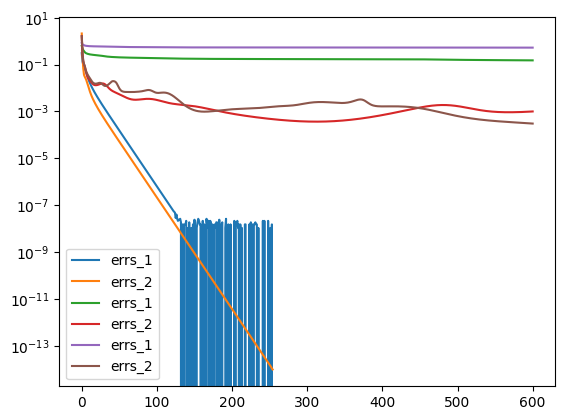

In [ ]:
np.random.seed(2)

# als_multilinear
for dim in range(3, 6):
  n = 4
  A = np.random.randn(*([n] * dim))
  rank = dim ** 2
  X0 = [np.random.randn(n, rank) for _ in range(dim)]
  X, errs_1, errs_2 = als_multilinear(A, rank, 1e-14, X0, maxiter=600)
  plt.semilogy(errs_1, label='errs_1')
  plt.semilogy(errs_2, label='errs_2')
  plt.legend();
  assert errs_1[-1] < 0.8
  assert np.linalg.norm(full(X) - A) / np.linalg.norm(A) < 0.8

print("Tests passed")

## CP-разложение

### Подготвка
Будем испытвать CP-разложение на нейросети предобученной на MNIST

In [ ]:
import torch, torch.nn as nn
import torchvision, torchvision.transforms as tt

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="./data/",
    train=True,
    download=True,
    transform=tt.Compose([tt.ToTensor()]),
)

test_dataset = torchvision.datasets.MNIST(
    root="./data/",
    train=False,
    download=False,
    transform=tt.Compose([tt.ToTensor()]),
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.09MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
model = nn.Sequential(

    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(128),

    nn.Conv2d(128, 256, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.BatchNorm2d(256),

    nn.Conv2d(256, 512, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 1),
    nn.BatchNorm2d(512),

    nn.Conv2d(512, 512, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(512, 512, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 1),
    nn.BatchNorm2d(512),

    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(4096, 10),
    nn.Softmax(0)
)

In [ ]:
PATH = "/content/model"

model = model.to(device)
model.load_state_dict(torch.load(PATH, map_location=device))

<ipython-input-17-16a9e4fbc352>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH, map_location=device))


<All keys matched successfully>

In [ ]:
conv_layer = model[30]
weight = conv_layer.weight.cpu().detach().numpy()

print("Convolutional layer:\t{}".format(conv_layer))
print("Weight tensor shape:\t{}".format(weight.shape))

Convolutional layer:	Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Weight tensor shape:	(512, 512, 3, 3)


In [39]:
weight.shape

(512, 512, 3, 3)

Будем применять разложение для одного слоя

In [ ]:
conv_layer = model[30]
weight = conv_layer.weight.cpu().detach().numpy()

print("Convolutional layer:\t{}".format(conv_layer))
print("Weight tensor shape:\t{}".format(weight.shape))

Convolutional layer:	Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Weight tensor shape:	(512, 512, 3, 3)


Имеется тензор (512, 512, 3, 3), лучше будет сделать решейп, чтобы он стал (512, 512, 9)

In [ ]:
def vectorise_filters(weight):
    I, O, H, W = weight.shape
    assert H == W
    return weight.reshape(I, O, H * W)

def unfold_filters(weight):
    I, O, HW = weight.shape
    return weight.reshape(I, O, int(np.sqrt(HW)), int(np.sqrt(HW)))

In [ ]:
A = vectorise_filters(weight)
print("Weight tensor shape:\t{}".format(A.shape))

Weight tensor shape:	(512, 512, 9)


### Сжатие

In [ ]:
np.random.seed(0) #3 4

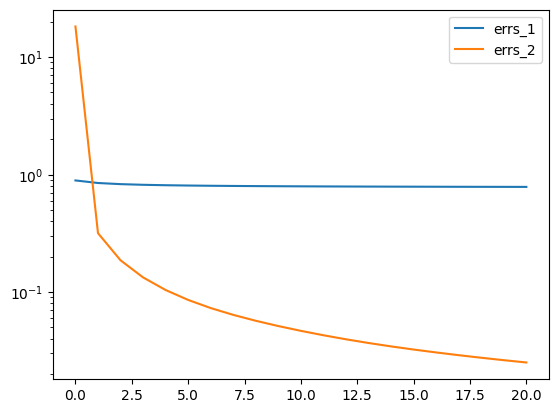

In [ ]:
R = 500
sz = A.shape
U0 = np.random.randn(sz[0], R)
V0 = np.random.randn(sz[1], R)
W0 = np.random.randn(sz[2], R)

X, errs_1, errs_2 = als_multilinear(A, R, 1e-14, (U0, V0, W0), maxiter=20)

plt.semilogy(errs_1, label='errs_1')
plt.semilogy(errs_2, label='errs_2')
plt.legend();

Разложение длится около 3 минут

In [ ]:
errs_1

[0.8911505903837195,
 0.8475828712549573,
 0.8288533401578193,
 0.8182590320198038,
 0.8113687743602264,
 0.8064812090146901,
 0.8027985707479938,
 0.7998984700476455,
 0.7975417739105741,
 0.7955840106458738,
 0.7939307649746061,
 0.7925154778596214,
 0.7912886670850857,
 0.790212651111422,
 0.789258674029384,
 0.7884049166874602,
 0.7876348204100605,
 0.7869356409733036,
 0.786297305544298,
 0.7857116116452529,
 0.7851717247944101]

Заметим что относительная ошибка около 80%

In [ ]:
U, V, W = X[0],X[1],X[2]

Число параметров в слое уменьшится с 512 * 512 * 9 до (512 + 512 + 9) * 500 , т.е. на 1842796 меньше

In [ ]:
class CPDConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, rank, padding):
        super(CPDConv2D, self).__init__()
        self.U = nn.parameter.Parameter(data=torch.rand(in_channels, rank))
        self.V = nn.parameter.Parameter(data=torch.rand(kernel_size**2, rank))
        self.W = nn.parameter.Parameter(data=torch.rand(out_channels, rank))
        self.bias = nn.parameter.Parameter(data=torch.rand(out_channels))
        self.padding = padding

    def forward(self, x):
        folded_convolution = full_with_torch((self.U.to(device), self.V.to(device), self.W.to(device)))
        convolution = unfold_filters(folded_convolution)
        return nn.functional.conv2d(x,convolution, bias=self.bias, padding=self.padding)

In [ ]:
factorized_layer = CPDConv2D(conv_layer.in_channels, conv_layer.out_channels, conv_layer.kernel_size[0], rank, conv_layer.padding)

factorized_layer.U.data = torch.tensor(U, dtype=torch.float)
factorized_layer.V.data = torch.tensor(V, dtype=torch.float)
factorized_layer.W.data = torch.tensor(W, dtype=torch.float)

factorized_layer.bias.data = model[30].bias

In [ ]:
from copy import deepcopy

def parameters_numel(model):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum(p.numel() for p in parameters)

compressed_model = copy.deepcopy(model)
compressed_model[30] = factorized_layer

print("Number of parameters in initial model:\t{}".format(parameters_numel(model)))
print("Number of parameters in compressed model:\t{}".format(parameters_numel(compressed_model)))

Number of parameters in initial model:	33473674
Number of parameters in compressed model:	31630878


### Fine-Tune

In [ ]:
from collections import defaultdict
from tqdm import tqdm
from IPython.display import clear_output

In [ ]:
def display_plots(history):
    fig, ax = plt.subplots(1,2, figsize=(12, 4))

    epochs = range(1, len(history['train_loss']) + 1)

    ax[0].plot(epochs, history['train_loss'], label='Training loss')
    ax[0].plot(epochs, history['val_loss'], label='Validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(epochs, history['train_accuracy'], label='Training acc')
    ax[1].plot(epochs, history['val_accuracy'], label='Validation acc')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

In [ ]:
def train_epoch(model, dataloader, optimizer):
    acc = 0
    loss = 0
    numel = 0
    ce_loss = nn.CrossEntropyLoss()
    progress_bar = tqdm(dataloader, position=0, leave=True)
    for data, target in progress_bar:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        cur_loss = ce_loss(output, target)
        cur_loss.backward()
        optimizer.step()
        pred = torch.argmax(output, 1)
        acc += torch.sum(pred == target).item()
        loss += cur_loss.item()
        numel += len(target)
    return loss / numel, acc / numel


def evaluate(model, dataloader):
    acc = 0
    loss = 0
    numel = 0
    ce_loss = nn.CrossEntropyLoss()
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        cur_loss =  ce_loss(output, target)
        pred = torch.argmax(output, 1)
        acc += torch.sum(pred == target).item()
        loss += cur_loss.item()
        numel += len(target)
    return loss / numel, acc / numel


def train(model, train_dataloader, test_dataloader, n_epochs, optimizer):
    history = defaultdict(list)
    for epoch in range(n_epochs):
        if epoch > 1:
            clear_output()
            display_plots(history)
        model.train()
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer)
        with torch.no_grad():
            model.eval()
            val_loss, val_acc = evaluate(model, test_dataloader)
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

    return history

In [ ]:
model = model.eval()
train_loss, train_acc = evaluate(model, train_dataloader)
test_loss, test_acc = evaluate(model, test_dataloader)

print("Train accuracy:\t{}".format(train_acc))
print("Test accuracy:\t{}".format(test_acc))

Train accuracy:	0.9324333333333333
Test accuracy:	0.9477


In [ ]:
compressed_model = compressed_model.eval()
train_loss, train_acc = evaluate(compressed_model, train_dataloader)
test_loss, test_acc = evaluate(compressed_model, test_dataloader)

print("Train accuracy:\t{}".format(train_acc))
print("Test accuracy:\t{}".format(test_acc))

Train accuracy:	0.9684833333333334
Test accuracy:	0.9735


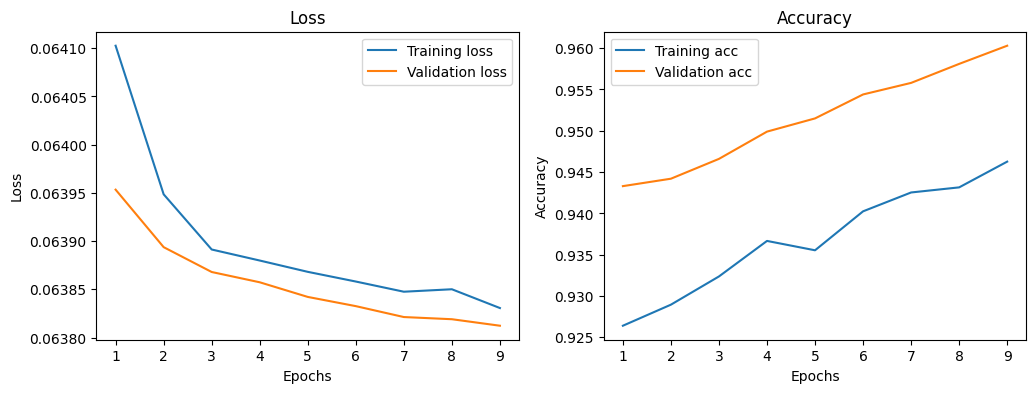

100%|██████████| 1875/1875 [00:49<00:00, 38.11it/s]


In [ ]:
n_epochs = 10
lr = 1e-3
weight_decay = 5e-4

optimizer = torch.optim.SGD(compressed_model.parameters(), lr=lr)
compressed_model = compressed_model.eval()

logs = train(compressed_model, train_dataloader, test_dataloader, n_epochs, optimizer)

Мы сжимаем только один слой для первого рассмотрения, более полное сжатие исследуют в статье: https://arxiv.org/pdf/1701.07148.pdf

### Реализация без подсчёта полного тензора

Существует также модификация из статьи https://arxiv.org/pdf/1412.6553v3.pdf, но её реализовывать не будем

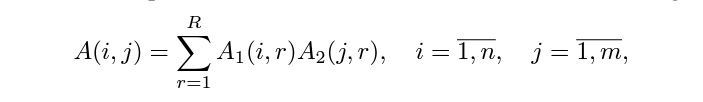

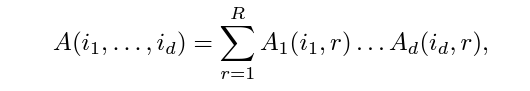

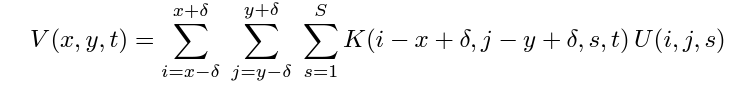

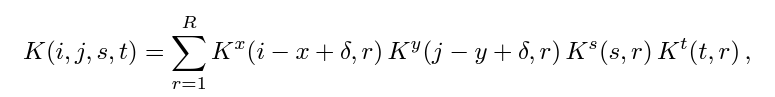

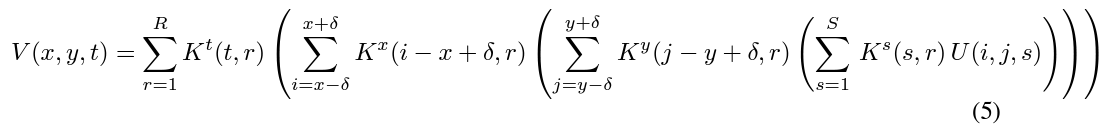

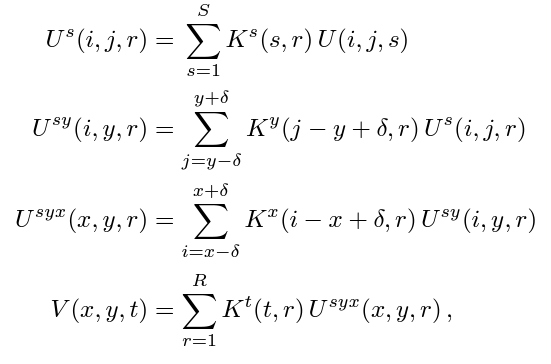